In [ ]:
import pandas as pd
# import polars as pl
# import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for regression
import statsmodels.formula.api as smf

#for the cpc data
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from collections import Counter

#Final Project!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Now you can access your files from Google Drive
file_path = '/content/drive/MyDrive/UChicago/2024-2025/AI & Innovation/'

Mounted at /content/drive


# Importing Datasets


In [ ]:
#function for creating table
def create_table(filepath, columns):
    df = pd.read_csv(filepath, sep='\t', usecols=columns, dtype={'patent_id': 'str'}).dropna(axis=0)
    for col in df.columns:
        if 'date' in col.lower():
            df[col] = pd.to_datetime(df[col])
    print(df.shape)
    return df

In [ ]:
#11 secs
columns = [0, 2]
patent_df = create_table(file_path + 'g_patent.tsv', columns)
patent_df.head()

(9075421, 2)


,patent_id,patent_date
0,10000000,2018-06-19
1,10000001,2018-06-19
2,10000002,2018-06-19
3,10000003,2018-06-19
4,10000004,2018-06-19


In [27]:
columns = [0, 5, 6]
comp_df = create_table(file_path + 'g_assignee_disambiguated.tsv', columns)
comp_df.head()

(8274997, 3)


,patent_id,disambig_assignee_organization,assignee_type
0,4488683,Metal Works Ramat David,3.0
1,11872626,"DIVERGENT TECHNOLOGIES, INC.",2.0
2,5856666,U.S. Philips Corporation,2.0
3,5204210,Xerox Corporation,2.0
4,5302149,COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...,7.0


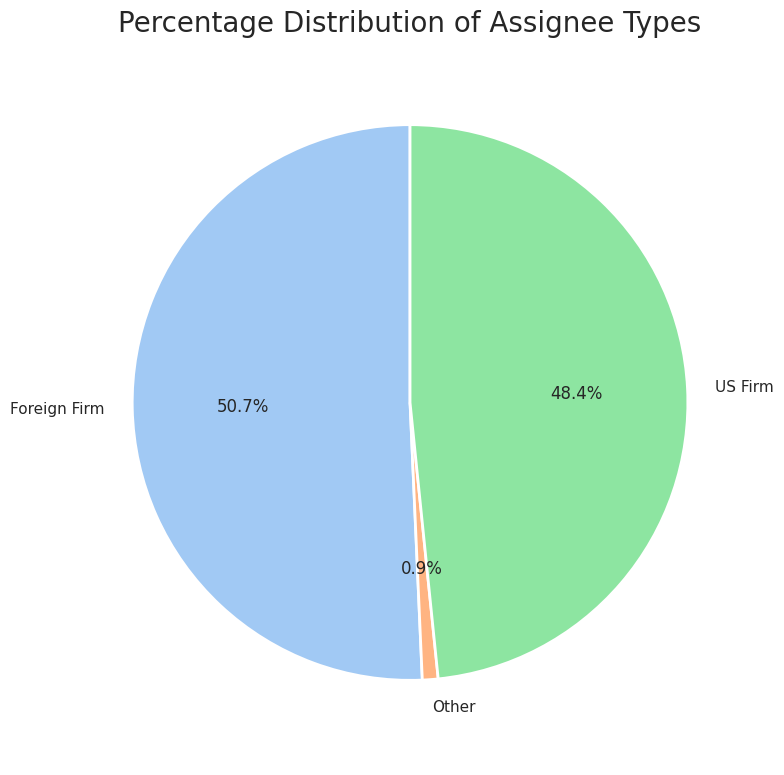

In [30]:
#looking at different sectors?
#did not have time to compare between us and foreign firms

def label_assignee(x):
    if x == 2.0:
        return 'US Firm'
    elif x == 3.0:
        return 'Foreign Firm'
    else:
        return 'Other'

comp_df['assignee_label'] = comp_df['assignee_type'].apply(label_assignee)

# Count frequency for each label
assignee_counts = comp_df['assignee_label'].value_counts().sort_index()

# Set seaborn style and color palette (using pastel colors)
sns.set_theme(style="whitegrid")
colors = sns.color_palette("pastel", len(assignee_counts))

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(assignee_counts, labels=assignee_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
plt.title("Percentage Distribution of Assignee Types", fontsize=20)
plt.axis('equal')  # Ensures the pie is drawn as a circle.
plt.tight_layout()
plt.savefig('assignee_pie.png', dpi=300)
# plt.show()


In [ ]:
# assignee_type_dict = {
#     1: "Unassigned (No Assignee)",
#     2: "U.S. Company or Corporation",
#     3: "Foreign Company or Corporation",
#     4: "U.S. Individual",
#     5: "Foreign Individual",
#     6: "U.S. Government",
#     7: "Foreign Government"}

In [ ]:
#takes 49 seconds
columns = [0, 1, 4]
cpc_df = create_table(file_path + 'g_cpc_current.tsv', columns)
cpc_df = cpc_df.loc[cpc_df['cpc_sequence'] == 0]
cpc_df = cpc_df.drop(columns='cpc_sequence')
cpc_df.head(10)

(55460284, 3)


,patent_id,cpc_subclass
0,3950000,A63C
4,3950001,A63C
7,3950002,A63C
11,3950003,A63C
15,3950004,B62B
17,3950005,B62B
22,3950006,F16C
25,3950007,B66C
29,3950008,B60G
31,3950009,C06B


In [ ]:
# cpc_sections = {
#     "A": "human necessities",
#     "B": "performing operations; transporting",
#     "C": "chemistry; metallurgy",
#     "D": "textiles; paper",
#     "E": "fixed constructions",
#     "F": "mechanical engineering; lighting; heating; weapons; blasting",
#     "G": "physics",
#     "H": "electricity",
#     "Y": "other"}

In [ ]:
columns = ["patent_id", "citation_patent_id", "citation_date"]
chunk_size = 50000000
df_list = []
for chunk in pd.read_csv(file_path + 'g_us_patent_citation.tsv', sep='\t', chunksize=chunk_size, usecols=columns,
                         dtype={'patent_id':'str'}):
    chunk['citation_date'] = pd.to_datetime(chunk['citation_date'], errors='coerce')
    chunk.dropna(inplace=True)
    df_list.append(chunk)
cit_df = pd.concat(df_list, ignore_index=True)

# cit_df = create_table('/Users/joycezhang/Downloads/g_us_patent_citation.tsv', columns, nrows=5000000)
print(cit_df.shape)
cit_df.head()

(145876693, 3)


,patent_id,citation_patent_id,citation_date
0,10000000,5093563,1992-03-01
1,10000000,5751830,1998-05-01
2,10000001,7804268,2010-09-01
3,10000001,9022767,2015-05-01
4,10000001,9090016,2015-07-01


In [ ]:
#looking at patents published per year
#I was doing this out of order and I can't remember how I got the df cumulative patents
#please just now this was the first graph in the final project

# sns.set_style("white")

# plt.figure(figsize=(8, 6))
# ax = sns.lineplot(x="year", y="cumulative_patents", data=cumulative_patents, marker="o")
# ax.grid(False)
# plt.title("Patents Per Year", fontsize=15)
# plt.xlabel("Year")
# plt.ylabel("Patent Count (Thousands)")
# plt.tight_layout()
# plt.savefig('patents.png', dpi=300)

In [ ]:
#counting citations per patent
# cit_count = cit_df.groupby(['citation_patent_id', 'citation_date']).size().reset_index(name='count')
# cit_count.head()

chunk_size = 10_000_000  # Define your chunk size
cit_count_list = []  # List to accumulate chunk results

for start in range(0, len(cit_df), chunk_size):
    chunk = cit_df.iloc[start:start+chunk_size]
    chunk_count = chunk.groupby(['citation_patent_id', 'citation_date']).size().reset_index(name='count')
    cit_count_list.append(chunk_count)

cit_count = pd.concat(cit_count_list, ignore_index=True)
cit_count.head()

,citation_patent_id,citation_date,count
0,1,1836-07-01,1
1,10000006,2018-06-01,1
2,1000001,1911-08-01,2
3,10000022,2018-06-01,1
4,10000035,2018-06-01,1


In [ ]:
#look at self-citations --> what percentage of the citations are from themselves
#we didn't have time for this

# Citation counts + averages

In [ ]:
#merging with company to calculate cumulative citation per company over time
cit_merge = pd.merge(cit_count, comp_df, left_on='citation_patent_id', right_on='patent_id', how='inner').sort_values(by='citation_date')
cit_merge['cumulative_count'] = cit_merge.groupby(by='disambig_assignee_organization')['count'].cumsum()
cit_merge.head()

,citation_patent_id,citation_date,count,patent_id,disambig_assignee_organization,cumulative_count
9836161,4725898,1688-02-01,1,4725898,"Victor Company of Japan, Ltd.",1
10057893,5008457,1691-04-01,1,5008457,E.I. DU PONT DE NEMOURS AND COMPANY,1
10192923,5187021,1693-02-01,1,5187021,"Diamond Fiber Composites, Inc.",1
23674405,D334043,1693-03-01,1,D334043,Sony Group Corporation,1
23583894,8820300,1700-01-01,1,8820300,"HITACHI AUTOMOTIVE SYSTEMS, LTD.",1


In [ ]:
#calculating the average number of citations per patent in each year per company
cit_year = cit_merge.copy()
cit_year['citation_date'] = pd.to_datetime(cit_year['citation_date'])
cit_year['year'] = cit_year['citation_date'].dt.year
cit_year = cit_year.groupby(['year', 'disambig_assignee_organization', 'count'])['citation_patent_id'].count().reset_index(name='citation_count')
cit_year = cit_year[(cit_year['year'] >= 1973) & (cit_year['year'] <= 2025)]
avg_cit = cit_year.groupby(['year', 'disambig_assignee_organization'])['citation_count'].mean().reset_index(name='avg_citations_per_patent')
cit_year.head()

,year,disambig_assignee_organization,count,citation_count
4633,1973,AB Akerlund & Rausing,1,1
4634,1973,"ALLIED CONSULTING, INC.",1,1
4635,1973,"ALPS ELECTRIC CO., LTD.",1,2
4636,1973,ALZA CORPORATION,1,1
4637,1973,AMP LLC,1,2


In [ ]:
# Ensure the data is sorted by year
# cit_year = cit_year.sort_values(by='year')

# # Set up the plot
# plt.figure(figsize=(10, 6))

# # Plot the citations per year
# sns.lineplot(x='year', y='citation_count', data=cit_year, marker='o')

# # Add labels and title
# plt.title('Citations Per Year')
# plt.xlabel('Year')
# plt.ylabel('Number of Citations')

# # Show the plot
# plt.tight_layout()
# plt.savefig('citations_per_year.png', dpi=300)
# plt.show()

#this is not included in the paper anymore, just wanted to see it before

In [ ]:
#how many companies do we have? helps us determine the size of top companies
print(avg_cit['disambig_assignee_organization'].nunique())

In [ ]:
#pick top N companies then create a dummy variable to run in regression
top_comps_1 = avg_cit.groupby('disambig_assignee_organization')['avg_citations_per_patent'].mean().sort_values(ascending=False).head(200).index
avg_cit['dummy_comp'] = avg_cit['disambig_assignee_organization'].apply(lambda x: 1 if x in top_comps_1 else 0)
#in future work I plan to instatiate the 0 citations
avg_cit.head()

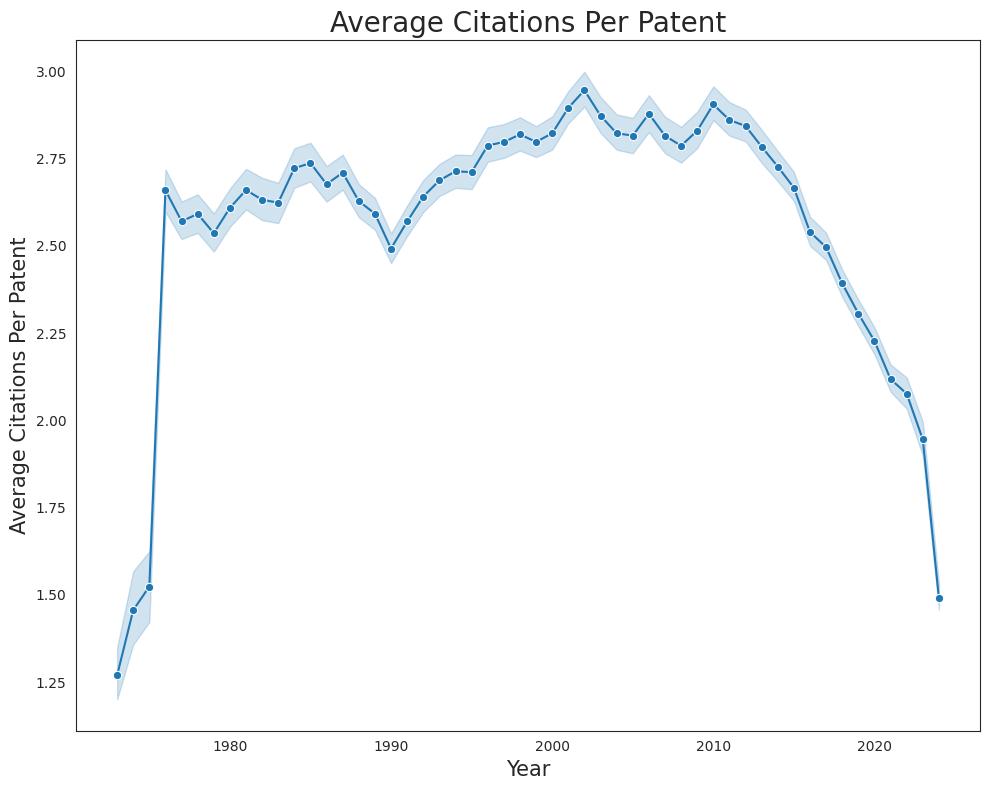

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(x='year', y='avg_citations_per_patent', data=avg_cit, marker='o')

# Add labels and title
plt.title('Average Citations Per Patent', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Citations Per Patent',fontsize=15)

# Show the plot
plt.tight_layout()
plt.savefig('citations', dpi=300)

# Citation Average Regression

In [ ]:
avg_cit['year_std'] = (avg_cit['year'] - avg_cit['year'].mean()) / avg_cit['year'].std()
avg_cit['year_sq_std'] = avg_cit['year_std'] ** 2

model = smf.ols(f'avg_citations_per_patent ~ dummy_comp*year_std + dummy_comp*year_sq_std', data=avg_cit).fit()
model.summary()

# CPC Analysis

In [ ]:
#beginning of cpc analysis
cpc_patent_df = pd.merge(cpc_df, patent_df, on='patent_id', how='inner').sort_values(by='patent_date')
cpc_patent_df.head()

In [ ]:
cpc_df.shape

In [ ]:
#merge cpc data with company data
cpc_merge = pd.merge(cpc_patent_df, comp_df, on='patent_id', how='inner')
print(cpc_merge.shape)
cpc_merge.head()

In [ ]:
#collect into cpc_subclass lists:
cpc_map = cpc_merge.groupby("disambig_assignee_organization")["cpc_subclass"].apply(list).to_dict()
cpc_map_list = [list(cpc_array) for cpc_array in cpc_map.values()]
#note that this dictionary is in alphabetical order

In [ ]:
#word2vec model for analyzing cpc distances
cpc_model = Word2Vec(sentences=cpc_map_list, vector_size=100, window=5, min_count=1, sg=1, workers=4, seed=42)

In [ ]:
similar_cpcs = cpc_model.wv.most_similar("G06F", topn=5) #ELECTRIC DIGITAL DATA PROCESSING
print(similar_cpcs)
#most similar with	TRANSMISSION OF DIGITAL INFORMATION, COMPUTING ARRANGEMENTS BASED ON SPECIFIC COMPUTATIONAL MODELS, STATIC STORES (semiconductor memory devices)

In [ ]:
#visualization for semantic space:
cpc_frequencies = cpc_merge['cpc_subclass'].value_counts()[:100]
words = list(cpc_frequencies.index)
word_vectors = np.array([cpc_model.wv[word] for word in words])
word_frequencies = list(cpc_frequencies.values)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_vectors)

In [ ]:
#graph of semantic space:

# Scatter plot of the 2D embeddings
plt.figure(figsize=(12, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], s=5)
            # s=word_frequencies,  # Size of points based on frequency
            # alpha=0.6, edgecolors="w", linewidth=0.5)

# Annotate the points with the CPC subclasses
for i, word in enumerate(words):
    # Adjust the font size based on the frequency of the word
    font_size = 5 + (word_frequencies[i]/10000)  # Calculate font size based on frequency
    font_size = np.clip(font_size, 8, 25)  # Scale font size between 8 and 25

    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]),
                 fontsize=font_size, alpha=0.7)

plt.title("Semantic Space of Top 100 CPC Subclasses", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.savefig('cpc_space.png', dpi=300)

#very different from A61B which is Diagnosis; Surgery; Identification

## Top CPC Analysis

In [ ]:
#innovation score
top_comp_cpc = cpc_merge.groupby(by=['disambig_assignee_organization', 'cpc_subclass']).size().reset_index(name='count')
top_comp_cpc = top_comp_cpc.loc[top_comp_cpc.groupby('disambig_assignee_organization')['count'].idxmax()]


In [ ]:
# companies = list(top_comp_cpc['disambig_assignee_organization'])
# top_subclass_per_comp = list(top_comp_cpc['cpc_subclass'])

In [ ]:
top_comp_cpc.loc[top_comp_cpc['disambig_assignee_organization']=='International Business Machines Corporation']

In [ ]:
cpc_sim = pd.merge(cpc_merge, top_comp_cpc, on='disambig_assignee_organization', how='inner').drop(columns=['count']).rename(columns={'cpc_subclass_x': 'patent_cpc',
                                                                                                                                      'cpc_subclass_y': 'top_cpc'})
cpc_sim.head()

In [ ]:
vec_top_cpc = np.vstack([cpc_model.wv[word] for word in cpc_sim['top_cpc']])
vec_patent_cpc = np.vstack([cpc_model.wv[word] for word in cpc_sim['patent_cpc']])

# Compute cosine similarity efficiently
cos_sim = np.einsum('ij,ij->i', vec_top_cpc, vec_patent_cpc) / (np.linalg.norm(vec_top_cpc, axis=1) * np.linalg.norm(vec_patent_cpc, axis=1))

# Store results
cpc_sim['similarity'] = cos_sim
cpc_sim.head()

In [ ]:
avg_sim = cpc_sim[['patent_date', 'disambig_assignee_organization', 'similarity']].copy()
avg_sim.loc[:, 'year'] = cpc_sim['patent_date'].dt.year
avg_sim_df = avg_sim.groupby(by=['disambig_assignee_organization', 'year'])['similarity'].mean().reset_index()
avg_sim_df.head()

In [ ]:
#excluding the ones that only have one line:
top_avg_sim_df = avg_sim_df.loc[avg_sim_df['similarity'] < 1].copy()

In [ ]:
#plotting figure
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='similarity', data=top_avg_sim_df, marker='o')

# Add labels and title
plt.title('Average Similarity Per Patent', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Similarity Per Patent', fontsize=15)

# Show the plot
plt.tight_layout()
plt.savefig('similarity', dpi=300)

In [ ]:
#plotting figure
mag7 = ['Apple Inc.', 'NVIDIA Corporation', 'Microsoft Corporation', 'GOOGLE LLC', 'Tesla Motors, Inc.', 'META PLATFORMS, INC.', 'Amazon Technologies, Inc.']

plt.figure(figsize=(12, 8))
mag7_df = top_avg_sim_df.loc[(top_avg_sim_df['disambig_assignee_organization'].isin(mag7)) & (top_avg_sim_df['year'] > 1987)]

sns.lineplot(x='year', y='similarity',
             data=mag7_df, marker='o')

# Add labels and title
plt.title('Mag 7 Average Similarity Per Patent', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Similarity Per Patent', fontsize=15)

# Show the plot
plt.tight_layout()
plt.savefig('mag7.png', dpi=300)

In [ ]:
top_comps = comp_df['disambig_assignee_organization'].value_counts().head(10000).index.to_list()
top_avg_sim_df['dummy_comp'] = top_avg_sim_df['disambig_assignee_organization'].apply(lambda x: 1 if x in top_comps else 0)

#standardize year before regression
#try a year dummy year variable
top_avg_sim_df['year_std'] = (top_avg_sim_df['year'] - top_avg_sim_df['year'].mean()) / top_avg_sim_df['year'].std()

model = smf.ols(f'similarity ~ dummy_comp*year_std', data=top_avg_sim_df).fit()
model.summary()

## Top CPC Regression

In [ ]:
model = smf.ols(f'similarity ~ year_std', data=top_avg_sim_df).fit()
model.summary()

In [ ]:
top_avg_sim_df.head()

NameError: name 'top_avg_sim_df' is not defined

## Citation CPC Analysis

In [ ]:
cpc_cit_1 = pd.merge(cpc_df, cit_df, on='patent_id', how='inner')
cpc_cit_1.head()

In [ ]:
cpc_cit_2 = pd.merge(cpc_cit_1, cpc_df, left_on = 'citation_patent_id', right_on='patent_id', how='inner')
cpc_cit_2.head()

In [ ]:
cpc_cit_2 = cpc_cit_2.drop(columns=['patent_id_y'])

In [ ]:
cpc_cit_2.shape

In [ ]:
# vec_y_cpc = np.vstack([cpc_model.wv[word] for word in cpc_cit_2['cpc_subclass_y']])
# vec_x_cpc = np.vstack([cpc_model.wv[word] for word in cpc_cit_2['cpc_subclass_x']])

# # Compute cosine similarity efficiently
# cos_sim = np.einsum('ij,ij->i', vec_y_cpc, vec_x_cpc) / (np.linalg.norm(vec_y_cpc, axis=1) * np.linalg.norm(vec_x_cpc, axis=1))

# cpc_cit_2['similarity'] = cos_sim
# cpc_cit_2.head()

In [ ]:
def compute_similarity(batch):
    vec_y_cpc = np.vstack([cpc_model.wv[word] for word in batch['cpc_subclass_y']])
    vec_x_cpc = np.vstack([cpc_model.wv[word] for word in batch['cpc_subclass_x']])

    # Compute cosine similarity efficiently
    cos_sim = np.einsum('ij,ij->i', vec_y_cpc, vec_x_cpc) / (
        np.linalg.norm(vec_y_cpc, axis=1) * np.linalg.norm(vec_x_cpc, axis=1)
    )

    return cos_sim

batch_size = 5_000_000  # Adjust based on available memory
num_batches = len(cpc_cit_2) // batch_size + 1

# Preallocate a list to store results (faster than DataFrame column assignment in loops)
similarities = np.empty(len(cpc_cit_2))

for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(cpc_cit_2))  # Avoid index errors
    similarities[start:end] = compute_similarity(cpc_cit_2.iloc[start:end])

# Assign back to DataFrame
cpc_cit_2['similarity'] = similarities

NameError: name 'cpc_cit_2' is not defined

In [ ]:
cpc_cit_2 = cpc_cit_2.drop(columns=['cpc_subclass_x', 'cpc_subclass_y', 'patent_id_x'])
cpc_cit_2.head()

In [ ]:
chunksize = 5_000_000
results = []

# Process data in chunks
for i in range(0, len(cpc_cit_2), chunksize):
    chunk = cpc_cit_2.iloc[i:i + chunksize]  # Extract chunk
    avg_chunk = chunk.groupby(by=["citation_patent_id", 'citation_date'], as_index=False)["similarity"].mean()
    results.append(avg_chunk)  # Store the result

# Combine all chunk results and compute final average
cpc_cit_sim = pd.concat(results).groupby(by=["citation_patent_id", 'citation_date'], as_index=False)["similarity"].mean()
cpc_cit_sim.head()

In [ ]:
cpc_cit_sim['year'] = cpc_cit_sim['citation_date'].dt.year
cpc_cit_sim  = cpc_cit_sim.drop(columns='citation_date')
cpc_cit_sim.head()

In [ ]:
cpc_cit_sim.head()

In [ ]:
big_merge = pd.merge(cpc_cit_sim, comp_df, left_on='citation_patent_id', right_on='patent_id', how='inner')
big_merge = big_merge.groupby(by=['disambig_assignee_organization', 'year'])['similarity'].mean().reset_index()
big_merge.head()

In [ ]:
big_merge_filtered = big_merge.loc[big_merge['similarity'] < 1].copy()
big_merge_filtered = big_merge_filtered.loc[(big_merge_filtered['year'] > 1973) & (big_merge_filtered['year'] < 2025)]

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='similarity', data=big_merge_filtered, marker='o')

# Add labels and title
plt.title('Average Patent-Citation Similarity', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Similarity', fontsize=15)

# Show the plot
plt.tight_layout()
plt.savefig('similarity', dpi=300)

## Citation CPC Regression

In [ ]:
top_comps = comp_df['disambig_assignee_organization'].value_counts().head(10000).index.to_list()
big_merge_filtered['dummy_comp'] = big_merge_filtered['disambig_assignee_organization'].apply(lambda x: 1 if x in top_comps else 0)

#standardize year before regression
#try a year dummy year variable
big_merge_filtered['year_std'] = (big_merge_filtered['year'] - big_merge_filtered['year'].mean()) / big_merge_filtered['year'].std()

model = smf.ols(f'similarity ~ dummy_comp*year_std', data=big_merge_filtered).fit()
model.summary()

NameError: name 'comp_df' is not defined